# Multi-label 감성분석 모델 학습
- 총 44개의 label = 감정(43개) + 없음감정(1)
- base model = koelectra

In [1]:
import os
import re
import pandas as pd
import numpy as np
from icecream import ic

from tqdm.auto import tqdm
from ast import literal_eval
from glob import glob
from pprint import pprint

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
import torchmetrics
from pytorch_lightning import LightningModule, Trainer, seed_everything, LightningDataModule
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger

from transformers import (
    AutoTokenizer, 
    ElectraTokenizer,
    ElectraConfig,
    ElectraModel, 
    ElectraForSequenceClassification,
    AutoModelForSequenceClassification, 
    AdamW, 
    pipeline, 
    AutoConfig, 
    get_linear_schedule_with_warmup
)

CONFIG_CLASSES = {
    "koelectra-base": ElectraConfig,
    "KcELECTRA-base": ElectraConfig,
    "koelectra-base-v3": ElectraConfig,
    "koelectra-small-v2": ElectraConfig,
    "koelectra-small-v3": ElectraConfig,
}

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm.auto import tqdm

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [2]:
LABELS = ['불평/불만', '환영/호의', '감동/감탄', '지긋지긋', '고마움', '슬픔', '화남/분노', '존경', '기대감', '우쭐댐/무시함', '안타까움/실망',
            '비장함', '의심/불신', '뿌듯함', '편안/쾌적', '신기함/관심', '아껴주는', '부끄러움', '공포/무서움', '절망', '한심함', '역겨움/징그러움', '짜증', 
            '어이없음', '없음', '패배/자기혐오', '귀찮음', '힘듦/지침', '즐거움/신남', '깨달음', '죄책감', '증오/혐오', '흐뭇함(귀여움/예쁨)', '당황/난처',
            '경악', '부담/안_내킴', '서러움', '재미없음', '불쌍함/연민', '놀람', '행복', '불안/걱정', '기쁨', '안심/신뢰']
print('감정 레이블 수: ',len(LABELS))

감정 레이블 수:  44


In [3]:
DATA_PATH = './KOTE_train_data/KOTE_origin_resource'
train_df = pd.read_csv(DATA_PATH + '/train.tsv', sep = '\t', header=None)
val_df = pd.read_csv(DATA_PATH + '/val.tsv', sep = '\t', header=None)
test_df = pd.read_csv(DATA_PATH + '/test.tsv', sep = '\t', header=None)
train_df.rename(columns={0:'idxs',1:'X',2:'Y'}, inplace=True)
val_df.rename(columns={0:'idxs',1:'X',2:'Y'}, inplace=True)
test_df.rename(columns={0:'idxs',1:'X',2:'Y'}, inplace=True)

In [4]:
id2label = {str(i): label for i, label in enumerate(LABELS)}
label2id = {label: i for i, label in enumerate(LABELS)}

# 다중-레이블에 대한 원핫 인코딩
class onehot_labels():
    LABELS = ['불평/불만', '환영/호의', '감동/감탄', '지긋지긋', '고마움', '슬픔', '화남/분노', '존경', '기대감', '우쭐댐/무시함', '안타까움/실망',
           '비장함', '의심/불신', '뿌듯함', '편안/쾌적', '신기함/관심', '아껴주는', '부끄러움', '공포/무서움', '절망', '한심함', '역겨움/징그러움', '짜증', 
           '어이없음', '없음', '패배/자기혐오', '귀찮음', '힘듦/지침', '즐거움/신남', '깨달음', '죄책감', '증오/혐오', '흐뭇함(귀여움/예쁨)', '당황/난처',
           '경악', '부담/안_내킴', '서러움', '재미없음', '불쌍함/연민', '놀람', '행복', '불안/걱정', '기쁨', '안심/신뢰']
    
    def __init__(self):
        self.id2label = {str(i): label for i, label in enumerate(LABELS)}
    
    def tup2list(self, x):
        if type(x) == tuple:
            return list(x)
        else:
            return [x]
    
    def do_onehot(self, dataframe):
        self.label_dict = {}
        for lab in LABELS:
            self.label_dict[lab] = []
            
        dataframe["lit_Y"] = dataframe['Y'].apply(lambda x: literal_eval(x))
        dataframe['list_Y'] = dataframe['lit_Y'].apply(lambda x: self.tup2list(x))
    
    
        # label2id = {label: i for i, label in enumerate(LABELS)}

        for _, data in tqdm(dataframe.iterrows(), total=len(dataframe)):
            list_label_range = []
            for i in range(44):
                list_label_range.append(i) # [0 ~ 43]
                
            for lab in data['list_Y']: # ex : (0, 6, 10, 22, 23, 36)
                # print(lab, data['list_Y'], idx)
                # category_num_found = list_label_range.pop(lab)
                category_num_found = lab
                self.label_dict[self.id2label.get(str(category_num_found))].append(1)
                list_label_range.remove(lab)
                    
            for category_num_left in list_label_range:
                self.label_dict[self.id2label.get(str(category_num_left))].append(0)
        
        return pd.DataFrame.from_dict(self.label_dict)

In [5]:
onehot_kote_labels = onehot_labels()

train_df_onehot = onehot_kote_labels.do_onehot(train_df)
test_df_onehot = onehot_kote_labels.do_onehot(test_df)
val_df_onehot = onehot_kote_labels.do_onehot(val_df)

train_df = pd.concat([train_df, train_df_onehot], axis=1)
test_df = pd.concat([test_df, test_df_onehot], axis=1)
val_df = pd.concat([val_df, val_df_onehot], axis=1)

print(len(train_df_onehot), len(train_df), len(val_df_onehot))
train_df.head(2)

100%|██████████| 5000/5000 [00:00<00:00, 18315.71it/s]


40000 40000 5000


,idxs,X,Y,lit_Y,list_Y,불평/불만,환영/호의,감동/감탄,지긋지긋,고마움,...,경악,부담/안_내킴,서러움,재미없음,불쌍함/연민,놀람,행복,불안/걱정,기쁨,안심/신뢰
0,39087,내가 톰행크스를 좋아하긴 했나보다... 초기 영화 빼고는 다 봤네.,"2,13,15,16,29,39","(2, 13, 15, 16, 29, 39)","[2, 13, 15, 16, 29, 39]",0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,30893,"정말 상상을 초월하는 무개념 진상들 상대하다 우울증, 공항장애 걸리는 공무원 많아요...","0,5,7,10,19,22,29,35,36,38","(0, 5, 7, 10, 19, 22, 29, 35, 36, 38)","[0, 5, 7, 10, 19, 22, 29, 35, 36, 38]",1,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0


In [6]:
val_df[val_df['X']==0] # 결측치 검증

# train_df.to_excel("KOTE_train_data_onehot.xlsx")
# val_df.to_excel("KOTE_val_data_onehot.xlsx")
# test_df.to_excel("KOTE_test_data_onehot.xlsx")

,idxs,X,Y,lit_Y,list_Y,불평/불만,환영/호의,감동/감탄,지긋지긋,고마움,...,경악,부담/안_내킴,서러움,재미없음,불쌍함/연민,놀람,행복,불안/걱정,기쁨,안심/신뢰


In [7]:
model_koelectra_addi_kote_mindcafe = "./koelectra-base-add-discriminator-kote-mind_1m800step"
ELECTRA_MODEL_NAME = model_koelectra_addi_kote_mindcafe
tokenizer = ElectraTokenizer.from_pretrained(ELECTRA_MODEL_NAME)
config = ElectraConfig.from_json_file(ELECTRA_MODEL_NAME+'/config.json')
electra_model = ElectraModel.from_pretrained(ELECTRA_MODEL_NAME+'/pytorch_model.bin', config=config)
print('tokenizer_test: %s' % (tokenizer.tokenize('작동함')))
electra_model.config

Some weights of the model checkpoint at ./koelectra-base-add-discriminator-kote-mind_1m800step/pytorch_model.bin were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_test: ['작동', '##함']


ElectraConfig {
  "_name_or_path": "./koelectra-base-add-discriminator-kote-mind_1m800step/pytorch_model.bin",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "base_model_prefix": "electra",
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 35000
}

In [8]:
# dataset 정의
class KoteDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: ElectraTokenizer,
        max_token_len: int = 512
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        comment_text = data_row.X
        labels = data_row[LABELS]
        encoding = self.tokenizer.encode_plus(
        comment_text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
        )
        
        return dict(
        comment_text=comment_text,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels)
        )

In [9]:
MAX_TOKEN_COUNT = 512
train_dataset = KoteDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
# tokenizer = ElectraTokenizer.from_pretrained(model_kc)
sample_item = train_dataset[0]
print(sample_item)
sample_item.keys()

{'comment_text': '음료가 몇푼이나 한다고.. 미국같으면 바로 바꿔줄텐데 참 어이없네요 그 카페', 'input_ids': tensor([    2,  9582,  4070,  2676,  5331, 17482,  6556,    18,    18,  6257,
         4872,  9234,  6422,  8586,  4612,  4788,  4244,  3425, 18513,  4116,
         4150,  2126,  7816,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,   

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [10]:
# <- 44개로 나와야함 -> 
# 더 크게 나온경우에는 concat을 여러번 돌려본것임.. 위에서 dataset처음부터 다시 읽어야 합니다.
print(len(sample_item['labels'])) 
sample_item['labels']

44


tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
# # passing sample batch through KoELECTRA:

# sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
# print(sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape)
# print(len(sample_batch['input_ids'])) # 8 문장이 한 batch에 들어감
# output = electra_model(sample_batch["input_ids"], sample_batch["attention_mask"])
# output.last_hidden_state.shape # output.pooler_output.shape # electra는 pooler output 없는것으로 알고있음

In [12]:
MAX_TOKEN_COUNT = 512
class KoteDataModule(LightningDataModule):
    
    def __init__(self, train_df, val_df, test_df, tokenizer, batch_size = 8, max_token_len = 128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        
    def setup(self, stage = None):
        self.train_dataset = KoteDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )
        
        self.test_dataset = KoteDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )
        
        self.val_dataset = KoteDataset(
            self.val_df,
            self.tokenizer,
            self.max_token_len
        )
                 
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle = False,
            num_workers=4
        )
        
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle = False,
            num_workers=4
        )
        
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle = False,
            num_workers=4
        )

In [13]:
N_EPOCHS = 200
BATCH_SIZE = 12

data_module = KoteDataModule(
    train_df,
    val_df,
    test_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [13]:
args = {
    # 'random_seed': 42, # Random Seed
    # 'model_type':'koelectra-base-v3',
    # 'pretrained_model': 'monologg/koelectra-base-v3-discriminator',  # Transformers PLM name
    # 'pretrained_tokenizer': '',  # Optional, Transformers Tokenizer Name. Overrides `pretrained_model`
    # 'batch_size': 32,
    # 'lr': 5e-6,  # Starting Learning Rate
    # 'epochs': 100,  # Max Epochs
    # 'max_length': 510,  # Max Length input size
    # 'train_data_path': TRAIN_PATH,  # Train Dataset file 
    # 'val_data_path': VALID_PATH,  # Validation Dataset file 
    # 'test_mode': False,  # Test Mode enables `fast_dev_run`
    # 'optimizer': 'AdamW',  # AdamW vs AdamP
    # 'lr_scheduler': 'exp',  # ExponentialLR vs CosineAnnealingWarmRestarts
    # 'fp16': True,  # Enable train on FP16(if GPU)
    # 'tpu_cores': 0,  # Enable TPU with 1 core or 8 cores
    # 'cpu_workers': os.cpu_count(),
    'id2label':id2label,
    'label2id':label2id,
}

In [14]:
class KoteCommentMLabelModel(LightningModule):
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.save_hyperparameters()
        self.electra = ElectraModel.from_pretrained(ELECTRA_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.electra.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        discriminator_hidden_states = self.electra(input_ids, attention_mask= attention_mask)
        pooled_output = discriminator_hidden_states.last_hidden_state[:,0,:]
        output = self.classifier(pooled_output)
        torch.cuda.empty_cache()
        
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
                
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        
        for i, name in enumerate(LABELS):
            #https://becominghuman.ai/pytorch-lightning-tutorial-2-using-torchmetrics-and-lightning-flash-901a979534e2
            class_roc_auc = torchmetrics.functional.auroc(predictions[:, i], labels[:, i])

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )

        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

c:\Users\82109\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


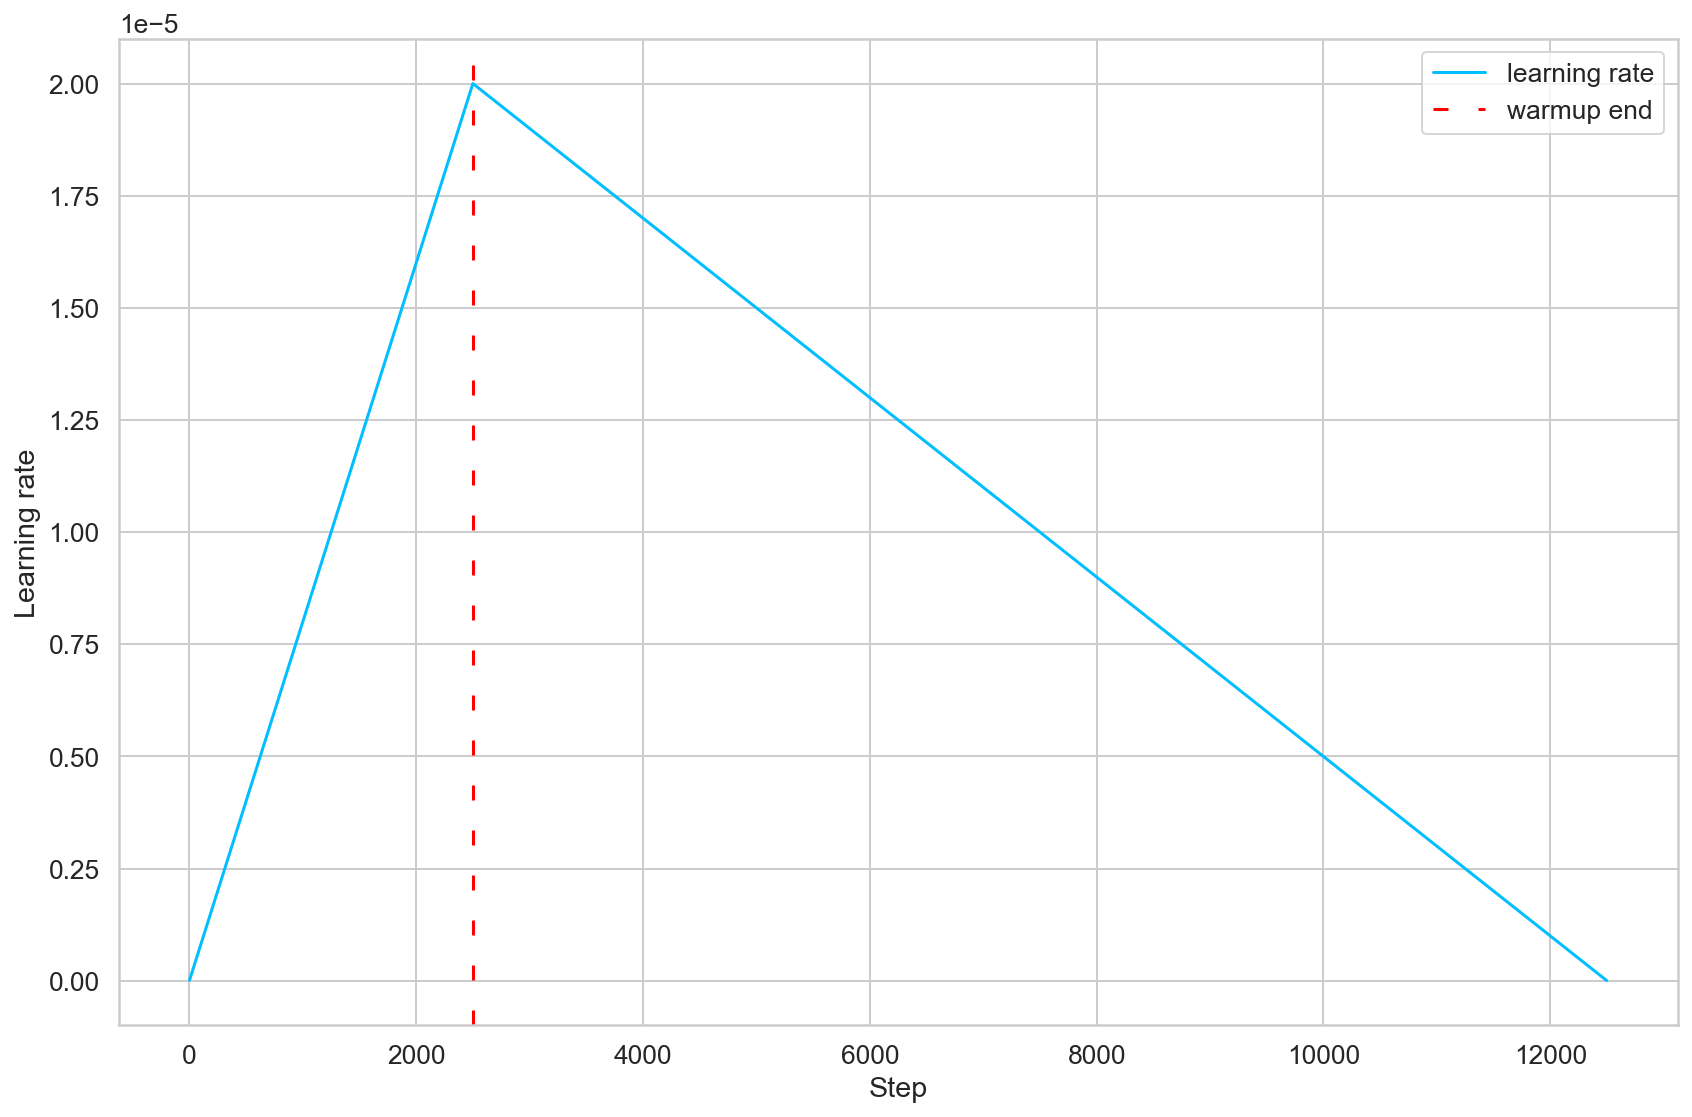

In [15]:
# The job of a scheduler is to change the learning rate of the optimizer during training.
# This might lead to better performance of our model. We’ll use the get_linear_schedule_with_warmup.

dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=2e-5)

warmup_steps = 2500
total_training_steps = 12500

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
    )

learning_rate_history = []
for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])
    
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout()

In [16]:
model = KoteCommentMLabelModel(
  n_classes=len(LABELS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at ./koelectra-base-add-discriminator-kote-mind_1m800step were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
'''
    "BackboneFinetuning",
    "BaseFinetuning",
    "Callback",
    "DeviceStatsMonitor",
    "EarlyStopping",
    "GPUStatsMonitor",
    "XLAStatsMonitor",
    "GradientAccumulationScheduler",
    "LambdaCallback",
    "LearningRateMonitor",
    "ModelCheckpoint",
    "ModelPruning",
    "ModelSummary",
    "BasePredictionWriter",
    "ProgressBar",
    "ProgressBarBase",
    "QuantizationAwareTraining",
    "RichModelSummary",
    "RichProgressBar",
    "StochasticWeightAveraging",
    "Timer",
    "TQDMProgressBar",
'''
checkpoint_callback = ModelCheckpoint(
    filename='epoch{epoch}-val_loss{val_loss:.4f}',
    monitor='val_loss',
    save_top_k=3,
    mode='max',
    auto_insert_metric_name=False,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=True,
    mode='max'
)

In [19]:
TB_NAME = "KOTE_trained_" + ELECTRA_MODEL_NAME
args = {
    # 'random_seed': 42, # Random Seed
    # 'model_type':'koelectra-base-v3',
    # 'pretrained_model': 'monologg/koelectra-base-v3-discriminator',  # Transformers PLM name
    # 'pretrained_tokenizer': '',  # Optional, Transformers Tokenizer Name. Overrides `pretrained_model`
    # 'batch_size': 32,
    'lr': 2e-5,  # Starting Learning Rate
    'epochs': 1,  # 에포크 수 설정 20이 적절함. 1은 테스트용
    # 'max_length': 510,  # Max Length input size
    # 'train_data_path': TRAIN_PATH,  # Train Dataset file 
    # 'val_data_path': VALID_PATH,  # Validation Dataset file 
    'test_mode': False,  # Test Mode enables `fast_dev_run`
    # 'optimizer': 'AdamW',  # AdamW vs AdamP
    # 'lr_scheduler': 'exp',  # ExponentialLR vs CosineAnnealingWarmRestarts
    'fp16': False,  # Enable train on FP16(if GPU)
    # 'tpu_cores': 0,  # Enable TPU with 1 core or 8 cores
    # 'cpu_workers': os.cpu_count(),
    # 'id2label':id2label,
    # 'label2id':label2id,
    # 'patience': 10, # for EarlyStopping
}

trainer = Trainer(
    callbacks=[checkpoint_callback],
    max_epochs=args['epochs'],
    fast_dev_run=False,
    num_sanity_val_steps = None if args['test_mode'] else 0,
    # For GPU Setup
    deterministic=torch.cuda.is_available(),
    gpus=[0] if torch.cuda.is_available() else None, # gpu 활용
    precision=16 if args['fp16'] and torch.cuda.is_available() else 32,
    logger = TensorBoardLogger("tb-logs", name=TB_NAME),
    log_every_n_steps = 20,
    profiler="simple",
)
trainer.fit(model, data_module)

In [ ]:
# 학습된 모델 불러오기
# Prediction
trained_model = KoteCommentMLabelModel.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABELS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
# 모델 테스트
test_comment = "감성분석 모델 학습이 잘 되었을까요?"

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=128,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
# trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABELS, test_prediction):
  print(f"{label}: {prediction}")


불평/불만: 0.3162122070789337
환영/호의: 0.2034670114517212
감동/감탄: 0.24613569676876068
지긋지긋: 0.20016233623027802
고마움: 0.16619738936424255
슬픔: 0.21534313261508942
화남/분노: 0.15932317078113556
존경: 0.18345524370670319
기대감: 0.1536790132522583
우쭐댐/무시함: 0.20168499648571014
안타까움/실망: 0.3145497441291809
비장함: 0.11921461671590805
의심/불신: 0.2149045467376709
뿌듯함: 0.18621374666690826
편안/쾌적: 0.13954538106918335
신기함/관심: 0.2442433387041092
아껴주는: 0.225502148270607
부끄러움: 0.18360722064971924
공포/무서움: 0.16309452056884766
절망: 0.16981881856918335
한심함: 0.11592046916484833
역겨움/징그러움: 0.14450928568840027
짜증: 0.27158811688423157
어이없음: 0.30566954612731934
없음: 0.23953905701637268
패배/자기혐오: 0.1566396802663803
귀찮음: 0.1598941534757614
힘듦/지침: 0.1868000477552414
즐거움/신남: 0.24051353335380554
깨달음: 0.18103274703025818
죄책감: 0.13325054943561554
증오/혐오: 0.19778142869472504
흐뭇함(귀여움/예쁨): 0.19874635338783264
당황/난처: 0.19339747726917267
경악: 0.1846698671579361
부담/안_내킴: 0.19482463598251343
서러움: 0.13396994769573212
재미없음: 0.20073090493679047
불쌍함/연민: